In [1]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
%matplotlib inline
%env CUDA_VISIBLE_DEVICES= 6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
# load data
train_X = np.load("all_img.npy")
train_attr = pd.read_csv("./hw4_data/train.csv")
test_attr = pd.read_csv("./hw4_data/test.csv")

# smiling_attr = np.hstack((np.repeat(np.array(train_attr["Smiling"]),2) 
#                           ,np.repeat(np.array(test_attr["Smiling"]),2)
#                          ))
smiling_attr = np.hstack((np.array(train_attr["Smiling"])
                          ,np.array(test_attr["Smiling"]))
                         )

In [3]:
# type transform
img_X = torch.from_numpy(train_X).type(torch.FloatTensor)
class_X = torch.from_numpy(smiling_attr).type(torch.FloatTensor).view(-1,1,1,1)

In [7]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 101, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
            
    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output
    
class Discriminator(nn.Module):
    def __init__(self, figsize=64):
        super(Discriminator, self).__init__()
        self.decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(figsize * 8, figsize *1, 4, 1, 0),
        )
        self.fc_dis = nn.Linear(figsize *1, 1)
        # aux-classifier fc
        self.fc_aux = nn.Linear(figsize *1, 1) # one class
        
        # softmax and sigmoid
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        decode_output = self.decoder(X)

        flat = decode_output.view(-1,64)
        fc_dis = self.fc_dis(flat)
        fc_aux = self.fc_aux(flat)
        
        realfake = self.sigmoid(fc_dis)
        classes = self.sigmoid(fc_aux)
        
        return realfake, classes

In [8]:
random.seed(38)
torch.manual_seed(38)
# use for random generation
up = np.ones(10)
down = np.zeros(10)
fixed_class = np.hstack((up,down))
fixed_class = torch.from_numpy(fixed_class).view(20,1,1,1).type(torch.FloatTensor)
fixed_noise = torch.randn(10, 100, 1, 1)
fixed_noise = torch.cat((fixed_noise,fixed_noise))
fixed_input = Variable(torch.cat((fixed_noise, fixed_class),1)).cuda()

In [10]:
# # loss functions
# dis_criterion = nn.BCELoss()
# aux_criterion = nn.BCELoss()

# # training
# latent_size = 100
# BATCH_SIZE = 64
# G = Generator()
# D = Discriminator()
# G.cuda()
# D.cuda()

# # setup optimizer
# beta_1 = 0.5
# optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(beta_1,0.999))
# optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1,0.999))


# D_loss_list = []
# G_loss_list = []
# D_fake_acc_list = []
# D_real_acc_list = []

# D_fake_class_list = []
# D_real_class_list = []

for epoch in range(200,300):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    D_fake_class = 0.0
    D_real_class = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = img_X[perm_index]
    train_class_sfl = class_X[perm_index]
    
#     # learning rate decay
#     if (epoch+1) == 5:
#         optimizerG.param_groups[0]['lr'] /= 2
#         optimizerD.param_groups[0]['lr'] /= 2
#         print("learning rate change!")

    if (epoch+1) == 15:
        optimizerG.param_groups[0]['lr'] /= 2
        optimizerD.param_groups[0]['lr'] /= 2
        print("learning rate change!")
    
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
        for _ in range(2):    
            # zero the parameter gradients
            D.zero_grad()
            input_X = train_X_sfl[index:index+BATCH_SIZE]
            intput_class = train_class_sfl[index:index+BATCH_SIZE]

            #### train with real image -> ground truth = real label
            real_image = Variable(input_X.cuda()) # use GPU 
            real_class = Variable(intput_class.cuda())
            real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
            dis_ouput, aux_output = D(real_image)
            D_real_dis_loss = dis_criterion(dis_ouput, real_label.view(BATCH_SIZE,1))
            D_real_aux_loss = aux_criterion(aux_output, real_class.view(BATCH_SIZE,1))
            D_real_acc += np.mean(((dis_ouput > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
            D_real_loss = (D_real_dis_loss + D_real_aux_loss)/2
            D_real_class += D_real_aux_loss.data[0]

            #### train with fake image -> ground truth = fake label
            noise = torch.randn(BATCH_SIZE, 100, 1, 1)
            fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)
            intput_vector =Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()

            fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
            fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()

            fake_image = G(intput_vector)
            dis_output, aux_output = D(fake_image.detach())
            D_fake_dis_loss = dis_criterion(dis_output, fake_label.view(BATCH_SIZE,1))
            D_fake_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
            D_fake_loss = (D_fake_dis_loss + D_fake_aux_loss)/2
            D_fake_acc += np.mean(((dis_output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
            D_fake_class += D_fake_aux_loss.data[0]
            # update D
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            epoch_D_loss+=(D_train_loss.data[0])

            optimizerD.step()
        
        #### train Generator
        for _ in range(1):
            G.zero_grad()
            # generate fake image
            noise = torch.randn(BATCH_SIZE, 100, 1, 1)
            fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)

            intput_vector = Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()

            fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()
            fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()

            fake_image = G(intput_vector)
            dis_output, aux_output = D(fake_image)
            G_dis_loss = dis_criterion(dis_output, fake_label_for_G.view(BATCH_SIZE,1))
            G_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
            G_train_loss = G_dis_loss + G_aux_loss
            G_train_loss.backward()
            optimizerG.step()
        epoch_G_loss += (G_train_loss.data[0])
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    
    print("D_real_dis_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_dis_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    print("D_real_aux_loss:", D_real_class/(total_length/BATCH_SIZE))
    print("D_fake_aux_loss:", D_fake_class/(total_length/BATCH_SIZE))
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))    
    D_real_class_list.append(D_real_class/(total_length/BATCH_SIZE))
    D_fake_class_list.append(D_fake_class/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_input)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './ACGAN_output2/fig3_3_'+str(epoch+1)+'.jpg',nrow=10)
    
torch.save(G.state_dict(), "./models/ACG2_model.pkt")

Epoch: 201
training D Loss: 0.0011421020753187253
training G Loss: 0.17403522638329114
D_real_dis_acc: 1.9827315173271391
D_fake_dis_acc: 1.9819572511203398
D_real_aux_loss: 0.009968810305889572
D_fake_aux_loss: 0.026979995631640774
Epoch: 202
training D Loss: 0.0009693441374329843
training G Loss: 0.17343768137958698
D_real_dis_acc: 1.9838577227188474
D_fake_dis_acc: 1.9837169470448839
D_real_aux_loss: 0.00875719331342292
D_fake_aux_loss: 0.024455633829343605
Epoch: 203
training D Loss: 0.0011505632236079339
training G Loss: 0.18145986862077004
D_real_dis_acc: 1.9831069191243753
D_fake_dis_acc: 1.9820980267943034
D_real_aux_loss: 0.011595254253171235
D_fake_aux_loss: 0.029302800784927856
Epoch: 204
training D Loss: 0.0011102514017304666
training G Loss: 0.18030987135844476
D_real_dis_acc: 1.9817226249970672
D_fake_dis_acc: 1.9805729569930317
D_real_aux_loss: 0.010998972013769454
D_fake_aux_loss: 0.028241004504187307
Epoch: 205
training D Loss: 0.001282558544545831
training G Loss: 0.1

training D Loss: 0.0011317507335522948
training G Loss: 0.18593269865560005
D_real_dis_acc: 1.9827315173271391
D_fake_dis_acc: 1.981253372750522
D_real_aux_loss: 0.010160831590822338
D_fake_aux_loss: 0.026279584516796857
Epoch: 238
training D Loss: 0.0006101274979545258
training G Loss: 0.18151835217631065
D_real_dis_acc: 1.9900518523732433
D_fake_dis_acc: 1.9896764505760072
D_real_aux_loss: 0.006869533488623567
D_fake_aux_loss: 0.024168873843681504
Epoch: 239
training D Loss: 0.0013818912893480586
training G Loss: 0.18362840803188474
D_real_dis_acc: 1.9808075831163041
D_fake_dis_acc: 1.9788601862931419
D_real_aux_loss: 0.009810945168468378
D_fake_aux_loss: 0.027033192416286517
Epoch: 240
training D Loss: 0.0008229298845925731
training G Loss: 0.18396455099720227
D_real_dis_acc: 1.986555923136482
D_fake_dis_acc: 1.985922432603646
D_real_aux_loss: 0.009835082712309644
D_fake_aux_loss: 0.02500211804473641
Epoch: 241
training D Loss: 0.0020189838576122835
training G Loss: 0.18582605198943

training D Loss: 0.0011672218721063446
training G Loss: 0.18679293330681632
D_real_dis_acc: 1.9821918772436122
D_fake_dis_acc: 1.9819103258956852
D_real_aux_loss: 0.008713188323575066
D_fake_aux_loss: 0.024512148382863103
Epoch: 274
training D Loss: 0.0009156111296743243
training G Loss: 0.18547025616245444
D_real_dis_acc: 1.985640881255719
D_fake_dis_acc: 1.984913540273574
D_real_aux_loss: 0.00803233050945215
D_fake_aux_loss: 0.025409422165626992
Epoch: 275
training D Loss: 0.0009570014197123964
training G Loss: 0.18698479186610031
D_real_dis_acc: 1.9849604654982285
D_fake_dis_acc: 1.9839515731681565
D_real_aux_loss: 0.007920739289858432
D_fake_aux_loss: 0.021184786870179106
Epoch: 276
training D Loss: 0.0006133464037793386
training G Loss: 0.18973898891550023
D_real_dis_acc: 1.989840688862298
D_fake_dis_acc: 1.9891368104924803
D_real_aux_loss: 0.006974233969637774
D_fake_aux_loss: 0.022468082432644733
Epoch: 277
training D Loss: 0.0011334749019155156
training G Loss: 0.18715506836680

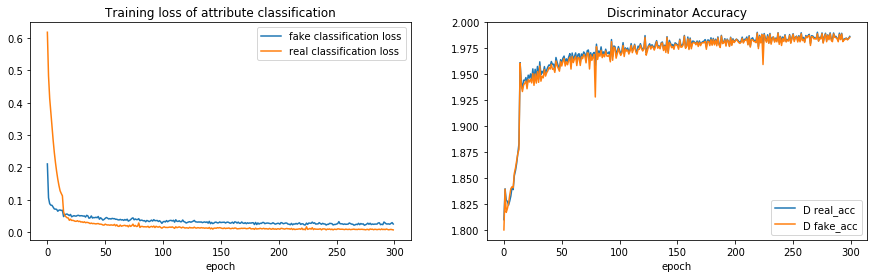

In [11]:
# plot loss
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(D_fake_class_list, label="fake classification loss")
plt.plot(D_real_class_list, label="real classification loss")
plt.title("Training loss of attribute classification")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(D_real_acc_list, label="D real_acc")
plt.plot(D_fake_acc_list, label="D fake_acc")
plt.title("Discriminator Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.savefig("./ACGAN_output2/fig3_2.jpg")
plt.show()